In [1]:
from run import build
import numpy as np
import torch
import matplotlib.pyplot as plt
torch.manual_seed(0)
np.random.seed(0)

In [2]:
pssm, ds_test = build(
    load_encoder_path="./networks/encoder.ckpt",
    load_decoder_path="./networks/decoder_net_dataset_100_10_8000_100.ckpt",
    load_decoder_dataset_path="./data/Datasets/decoder/decoder_dataset_100_5_1000_100.pt"
)

pssm.encoder.to('cpu')
pssm.decoder.to('cpu')

figures_path = './figures/'
analysis_path = './data/analysis'

Generating encoder dataset... Done.
Loading encoder from checkpoint... 1
Done.
Loading decoder from checkpoint... Done.
Creating PoissonSSM model... Done.


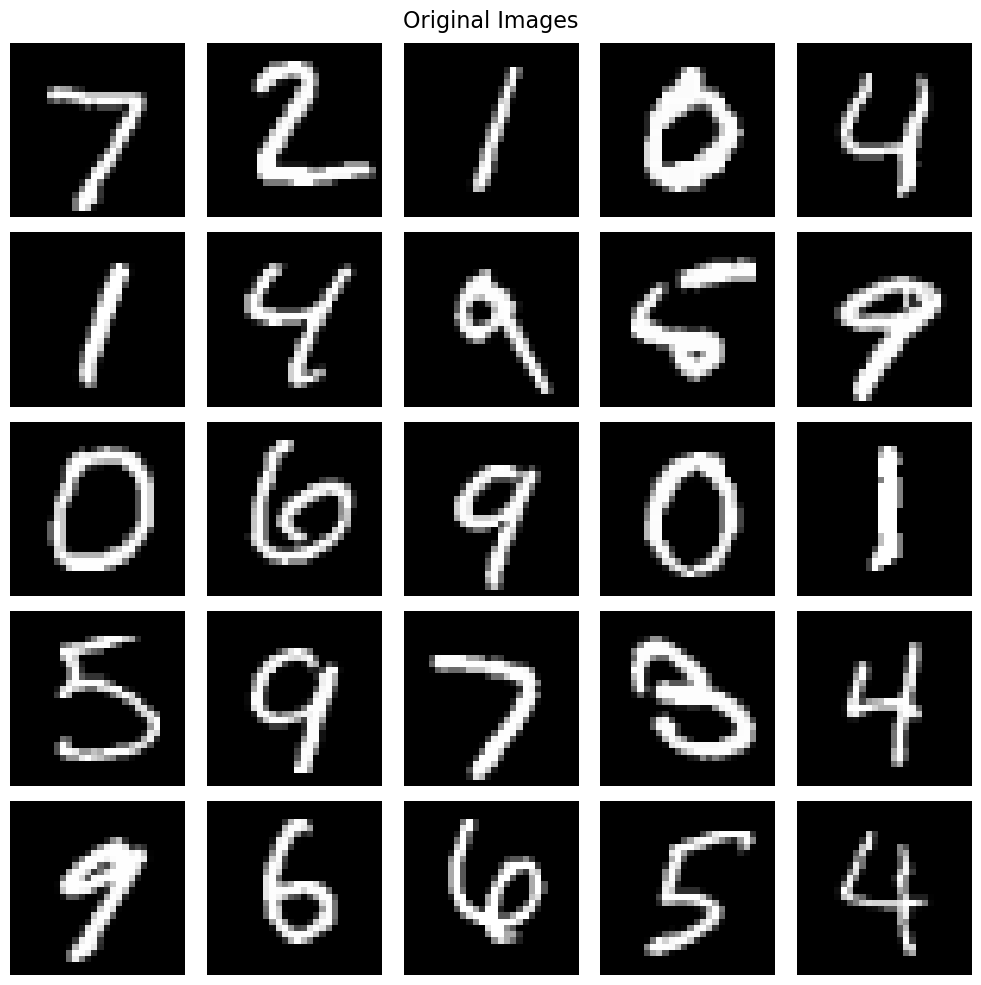

In [29]:
# create a 5 by 5 grid of subplots with the images (ds_test)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(ds_test):
        ax.imshow(ds_test[i][0].reshape(28, 28), cmap='gray')
    ax.axis('off')

# add title as original images
plt.suptitle("Original Images", fontsize=16)
plt.tight_layout()

fig.savefig(f"{figures_path}/og_images.svg", format='svg', dpi=300)

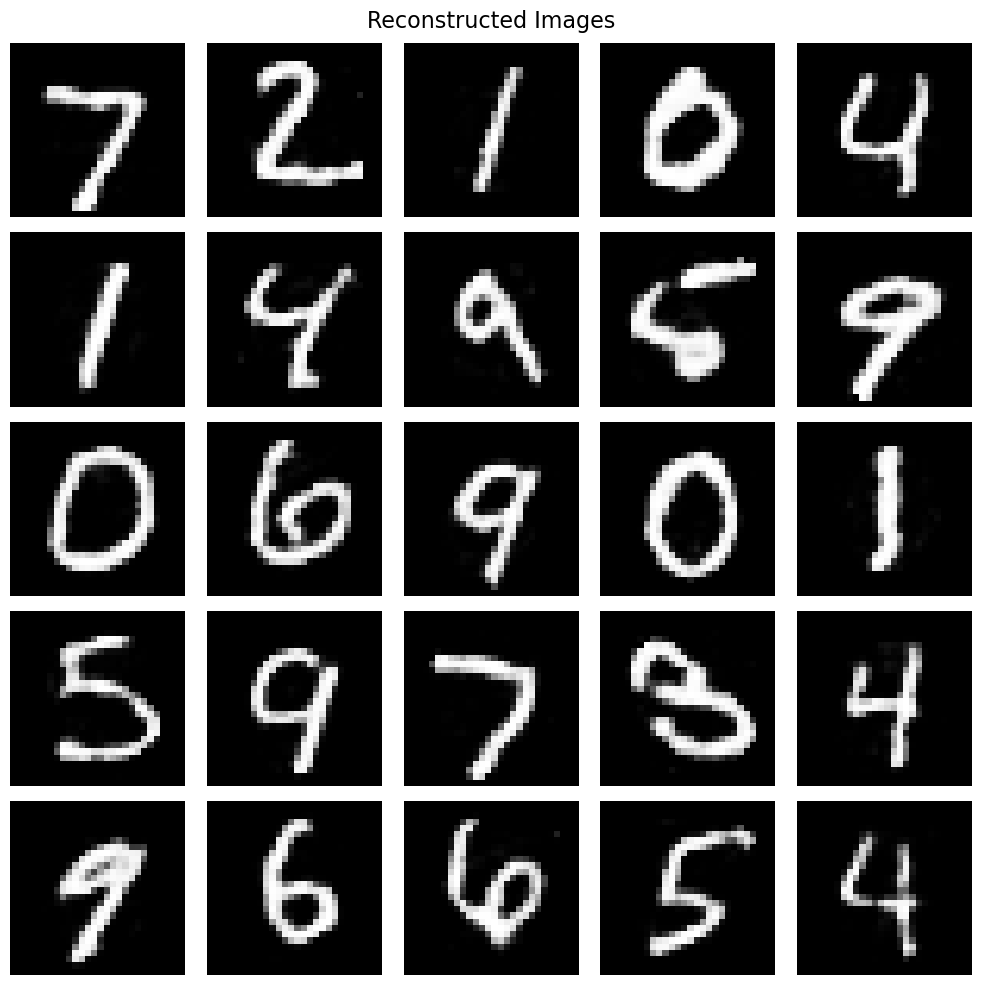

In [30]:
# create a 5 by 5 grid of subplots with the images (ds_test)
fig, axes = plt.subplots(5, 5, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < len(ds_test):
        img = ds_test[i][0]
        dist, du, z, y = pssm.encoder.forward(img.unsqueeze(0).unsqueeze(0))
        ax.imshow(y.detach().cpu().reshape(28, 28), cmap='gray')
    ax.axis('off')
plt.suptitle("Reconstructed Images", fontsize=16)

plt.tight_layout()
fig.savefig(f"{figures_path}/reconstructed_images.svg", format='svg', dpi=300)


In [13]:
threshold = .5
dt = 0.1


load_analysis_data = False
save_analysis_data = True
n_test_imgs = 250
n_img_repeats = 100


In [6]:
from tqdm.notebook import tqdm

thresholds = [.1, .2, .4, .6, .8]

all_rts = []
all_accuracies = []
for t in tqdm(thresholds):
    rts_per_threshold = []
    accuracies_per_threshold = []
    for img in range(10):
        img, label = ds_test[img]
        rts, actions, entropies, spikes = pssm.get_rts(img, threshold=t, n_repeats=200, plot_results=False, tqdm=False)
        rts_per_threshold.append(rts.mean().item())

        accuracy = (actions == label).float().mean()
        accuracies_per_threshold.append(accuracy.item())
    all_rts.append(rts_per_threshold)
    all_accuracies.append(accuracies_per_threshold)

  0%|          | 0/5 [00:00<?, ?it/s]

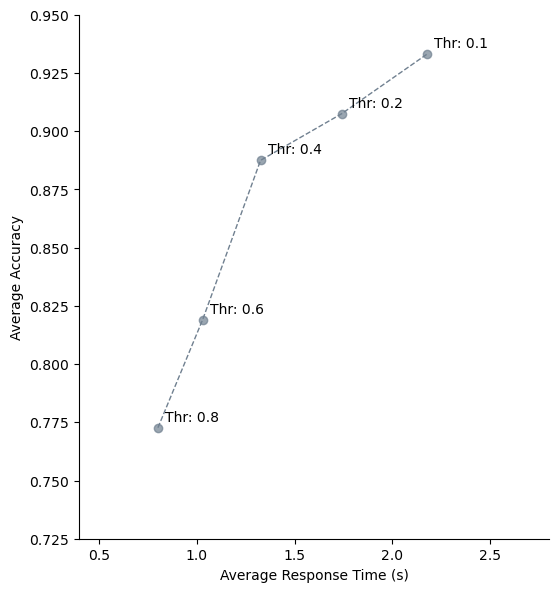

In [7]:
# Compute the average response time (converted to seconds) and average accuracy for each threshold
all_rts = np.array(all_rts)
all_accuracies = np.array(all_accuracies)
avg_rts = all_rts.mean(axis=1) * dt 
avg_accuracies = np.array(all_accuracies).mean(axis=1)

# Plot one point per threshold with average response time on the x-axis and accuracy on the y-axis
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(avg_rts, avg_accuracies, color='slategray', alpha=0.7)
for i, thr in enumerate(thresholds):
    ax.annotate(f"Thr: {thr}", (avg_rts[i], avg_accuracies[i]), textcoords="offset points", xytext=(5, 5))
ax.set_xlabel("Average Response Time (s)")
ax.set_ylabel("Average Accuracy")
# ax.set_title("Average Accuracy vs Response Time for Each Threshold")
# plot line through the points
ax.plot(avg_rts, avg_accuracies, color='slategray', linestyle='--', linewidth=1, alpha=1)

# remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()

ax.set_xlim(.1 * 4, .7* 4)
ax.set_ylim(.725, .95)

fig.savefig(f"{figures_path}/avg_accuracy_vs_response_time.svg", format='svg', dpi=300)
plt.show()


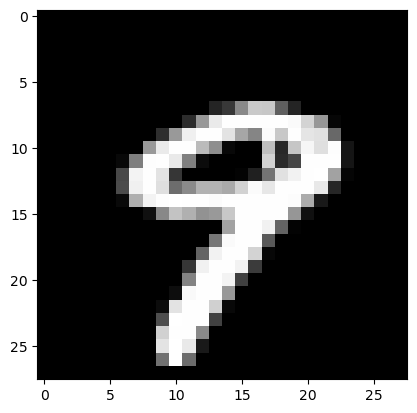

In [17]:
img = ds_test[9][0]
plt.imshow(img.reshape(28, 28), cmap='gray')

In [18]:
rts, actions, entropies, spikes = pssm.get_rts(img, threshold=threshold, n_repeats=1000, plot_results=False)

100%|██████████| 1000/1000 [00:11<00:00, 88.58it/s]


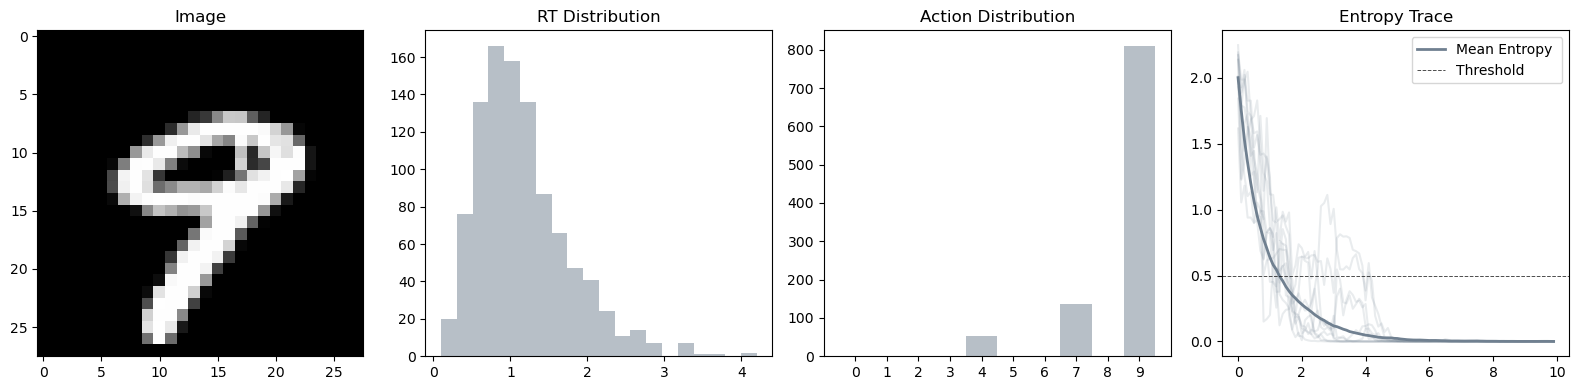

In [25]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].set_title("Image")
axs[0].imshow(img.reshape(28, 28), cmap='gray')

axs[1].hist(rts * dt, bins=20, color='slategray', alpha=0.5)
axs[1].set_title("RT Distribution")

bins = np.arange(11) - 0.5
axs[2].hist(actions, bins=bins, color='slategray', alpha=0.5)
axs[2].set_title("Action Distribution")
axs[2].set_xticks(np.arange(10))

axs[3].set_title("Entropy Trace")
for i in range(min(len(entropies), 10)):
    axs[3].plot(np.arange(len(entropies[i])) * dt, entropies[i], color='slategray', alpha=.15)

axs[3].plot(np.arange(len(entropies[0])) * dt, np.mean(entropies, axis=0), color='slategray', linewidth=2, label='Mean Entropy ')

# plot line at threshold
axs[3].axhline(y=threshold, color='black', linestyle='--', label='Threshold', linewidth=.7, alpha=0.7)
axs[3].legend()

plt.tight_layout()
fig.savefig(f"{figures_path}/single_digit.svg", format='svg', dpi=300)

plt.show()


In [32]:
from tqdm.notebook import trange
import numpy as np
import seaborn as sns

if load_analysis_data == False:
    mean_rts, mean_accuracies, mean_spikes = [], [], []
    correct_rts, incorrect_rts = [], []

    for i in trange(n_test_imgs):
        img, label = ds_test[i]
        rts, action, entropies, spikes = pssm.get_rts(
            img, threshold=threshold, n_repeats=n_img_repeats, plot_results=False, tqdm=False
        )
        
        # Compute mean rt for the current test
        rt_mean = np.mean(rts)
        mean_rts.append(rt_mean)
        
        # Check if response is correct
        correct_mask = action == label
        if correct_mask.any():
            correct_rts.append(rts[correct_mask])

        if (correct_mask == False).any():
            incorrect_rts.append(rts[~correct_mask])

        
        mean_accuracies.append((action == label).float().mean())
        mean_spikes.append(np.mean(spikes))

    mean_accuracies = np.array(mean_accuracies)
    mean_rts = np.array(mean_rts)
    mean_spikes = np.array(mean_spikes)

    correct_rts = np.concatenate(correct_rts).flatten()
    incorrect_rts = np.concatenate(incorrect_rts).flatten()
    if save_analysis_data:
        np.savez(
            f"{analysis_path}/analysis_data.npz",
            mean_rts=mean_rts,
            mean_accuracies=mean_accuracies,
            mean_spikes=mean_spikes,
            correct_rts=correct_rts,
            incorrect_rts=incorrect_rts
        )
else:
    # load analysis data from analysis_path
    data = np.load(f"{analysis_path}/analysis_data_2500.npz")
    mean_rts = data["mean_rts"]
    mean_accuracies = data["mean_accuracies"]
    mean_spikes = data["mean_spikes"]
    correct_rts = data["correct_rts"]
    incorrect_rts = data["incorrect_rts"]



  0%|          | 0/250 [00:00<?, ?it/s]

Mean RT for correct responses: 1.1225986826517558
Mean RT for incorrect responses: 1.449807544264819


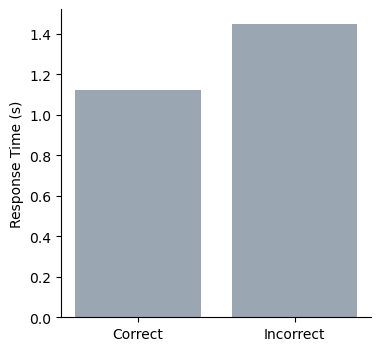

In [33]:
print("Mean RT for correct responses:", correct_rts.mean() * dt)
print("Mean RT for incorrect responses:", incorrect_rts.mean() * dt)

# Convert reaction time lists to numpy arrays and scale by dt (to get seconds)
correct_rts_sec = correct_rts * dt
incorrect_rts_sec = incorrect_rts * dt

# Compute means and standard error of the means (SEM)
mean_correct = correct_rts_sec.mean()
mean_incorrect = incorrect_rts_sec.mean()
sem_correct = correct_rts_sec.std(ddof=1) / np.sqrt(len(correct_rts_sec))
sem_incorrect = incorrect_rts_sec.std(ddof=1) / np.sqrt(len(incorrect_rts_sec))

# Plot the bar chart with error bars
labels = ['Correct', 'Incorrect']
means = [mean_correct, mean_incorrect]
sems = [sem_correct, sem_incorrect]

fig, ax = plt.subplots(figsize=(4, 4))
#ax.bar(labels, means, yerr=sems, capsize=10, color=['slategray', 'slategray'], alpha=0.7)
ax.bar(labels, means, capsize=10, color=['slategray', 'slategray'], alpha=0.7)
ax.set_ylabel('Response Time (s)')
#ax.set_title('Mean Reaction Time with Standard Errors')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(f"{figures_path}/rt_correct_incorrect.svg", format='svg', dpi=300)

plt.show()

In [41]:
np.argsort(mean_accuracies)[-10:][::-1]

array([130,  37,  25,  28,  71, 134, 128, 183,  10, 147])

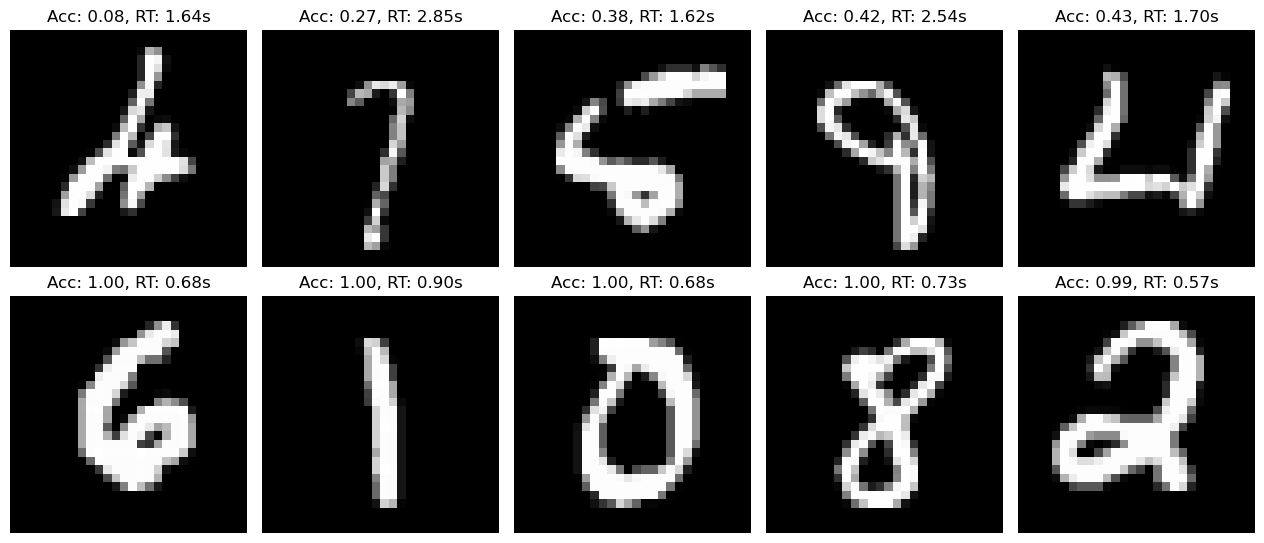

In [54]:
# Get indices of the 5 lowest accuracies
lowest_indices = np.array([247, 175, 8, 193, 33])

# Get indices of the 5 highest accuracies, reversed (from highest to lowest)
highest_indices = np.array([130, 37, 28, 134, 147])

# Create a figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot the lowest mean accuracy images on the first row (without class labels)
for i, idx in enumerate(lowest_indices):
    img, _ = ds_test[idx]
    axes[0, i].imshow(img.reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"Acc: {mean_accuracies[idx]:.2f}, RT: {(mean_rts[idx]*dt):.2f}s")
    axes[0, i].axis('off')

# Plot the highest mean accuracy images on the second row (without class labels)
for i, idx in enumerate(highest_indices):
    img, _ = ds_test[idx]
    axes[1, i].imshow(img.reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f"Acc: {mean_accuracies[idx]:.2f}, RT: {(mean_rts[idx]*dt):.2f}s")
    axes[1, i].axis('off')

# Add y-labels to the left-most subplots
axes[0, 0].set_ylabel("Lowest Accuracies (Ascending)", fontsize=12)
axes[1, 0].set_ylabel("Highest Accuracies (Descending)", fontsize=12)

# Adjust layout so that the y-labels are not clipped
plt.tight_layout(rect=[0.15, 0.03, 1, 0.95])
fig.savefig(f"{figures_path}/lowest_highest_accuracies.svg", format='svg', dpi=300)
plt.show()


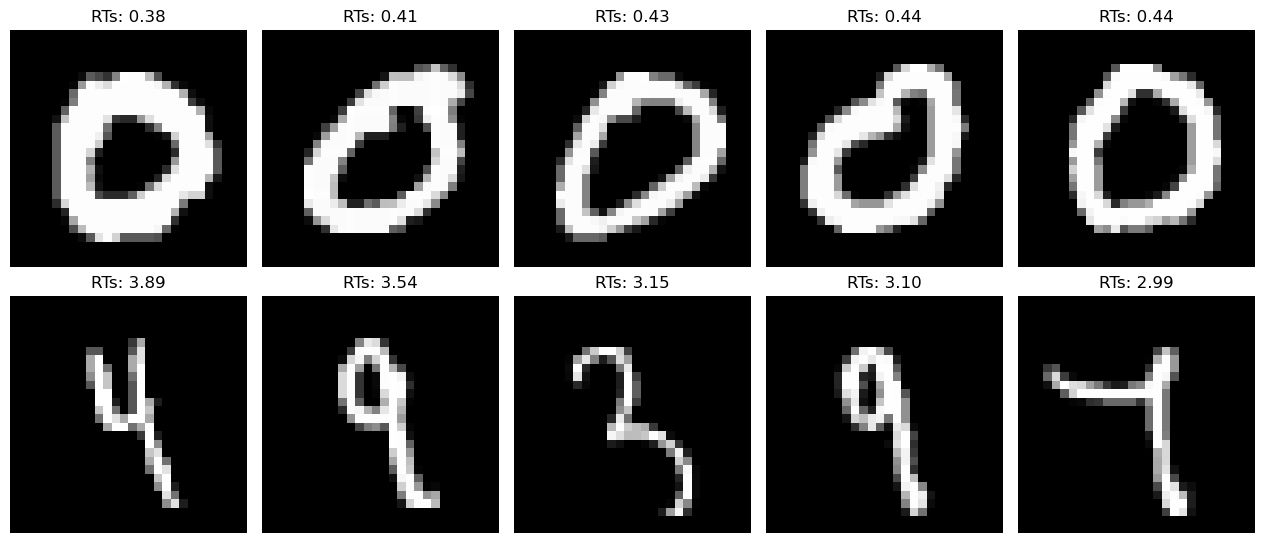

In [20]:
# Get indices of the 5 lowest accuracies
lowest_indices = np.argsort(mean_rts)[:5]

# Get indices of the 5 highest accuracies, reversed (from highest to lowest)
highest_indices = np.argsort(mean_rts)[-5:][::-1]

# Create a figure with 2 rows and 5 columns of subplots
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

# Plot the lowest mean accuracy images on the first row (without class labels)
for i, idx in enumerate(lowest_indices):
    img, _ = ds_test[idx]
    axes[0, i].imshow(img.reshape(28, 28), cmap='gray')
    axes[0, i].set_title(f"RTs: {(mean_rts[idx]*dt):.2f}")
    axes[0, i].axis('off')

# Plot the highest mean accuracy images on the second row (without class labels)
for i, idx in enumerate(highest_indices):
    img, _ = ds_test[idx]
    axes[1, i].imshow(img.reshape(28, 28), cmap='gray')
    axes[1, i].set_title(f"RTs: {(mean_rts[idx]*dt):.2f}")
    axes[1, i].axis('off')

# Add y-labels to the left-most subplots
axes[0, 0].set_ylabel("Lowest RTs (Ascending)", fontsize=12)
axes[1, 0].set_ylabel("Highest RTs (Descending)", fontsize=12)

# Adjust layout so that the y-labels are not clipped
plt.tight_layout(rect=[0.15, 0.03, 1, 0.95])
plt.show()


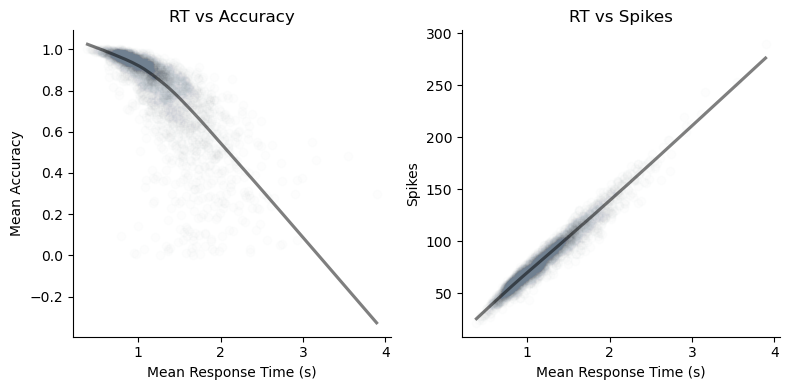

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

sns.regplot(
    x=np.array(mean_rts) * dt,
    y=mean_accuracies,
    lowess=True,
    scatter_kws={'alpha': .01},
    color='slategray',
    line_kws={'color': 'black', 'alpha': 0.5},
    ax=axes[0]
)
axes[0].set_xlabel('Mean Response Time (s)')
axes[0].set_ylabel('Mean Accuracy')
axes[0].set_title('RT vs Accuracy')


sns.regplot(
    x=np.array(mean_rts) * dt,
    y=mean_spikes,
    lowess=True,
    scatter_kws={'alpha': 0.01},
    color='slategray',
    line_kws={'color': 'black', 'alpha': 0.5},
    ax=axes[1]
)
axes[1].set_xlabel('Mean Response Time (s)')
axes[1].set_ylabel('Spikes')
axes[1].set_title('RT vs Spikes')


for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

fig.savefig(f"{figures_path}/rt_accuracy_spikes.svg", format='svg', dpi=300)

plt.tight_layout()
plt.show()

440


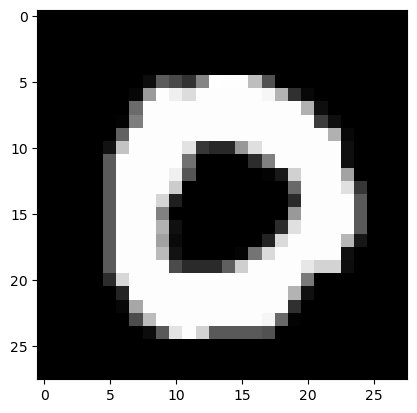

In [22]:
i = np.random.choice(np.argsort(mean_accuracies)[-5:][::-1])

highest_indices = i
plt.imshow(ds_test[i][0].reshape(28, 28), cmap='gray')
print(i)

434


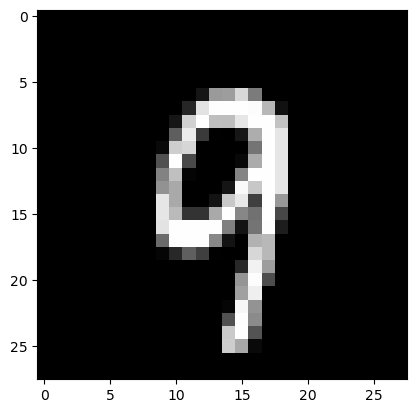

In [23]:
# randomly select 1 image from 
i = np.random.choice(np.argsort(mean_accuracies)[100:])
plt.imshow(ds_test[i][0].reshape(28, 28), cmap='gray')
print(i)

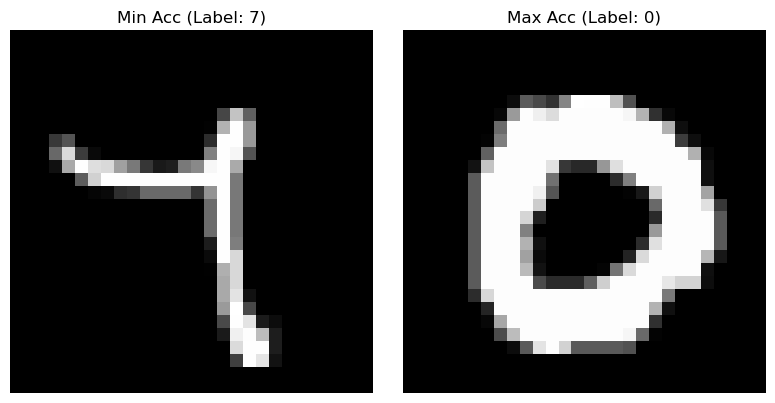

In [24]:
# get index with min accuracy
#min_accuracy_index = np.argmin(mean_accuracies)
min_accuracy_index = 358
min_img, min_label = ds_test[min_accuracy_index]

# get index with min accuracy
#max_accuracy_index = np.argmax(mean_accuracies)
max_accuracy_index = 440
max_img, max_label = ds_test[max_accuracy_index]


fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(min_img.reshape(28, 28), cmap='gray')
axes[0].set_title(f"Min Acc (Label: {min_label.item()})")
axes[0].axis('off')

axes[1].imshow(max_img.reshape(28, 28), cmap='gray')
axes[1].set_title(f"Max Acc (Label: {max_label.item()})")
axes[1].axis('off')

plt.tight_layout()

fig.savefig(f"{figures_path}/min_max_accuracy_images.svg", format='svg', dpi=300)
plt.show()

In [25]:
min_rts, min_actions, min_entropies, mins_spikes = pssm.get_rts(min_img, threshold=threshold, n_repeats=1000, plot_results=False)
max_rts, max_actions, max_entropies, max_spikes = pssm.get_rts(max_img, threshold=threshold, n_repeats=1000, plot_results=False)

100%|██████████| 1000/1000 [00:10<00:00, 91.21it/s]


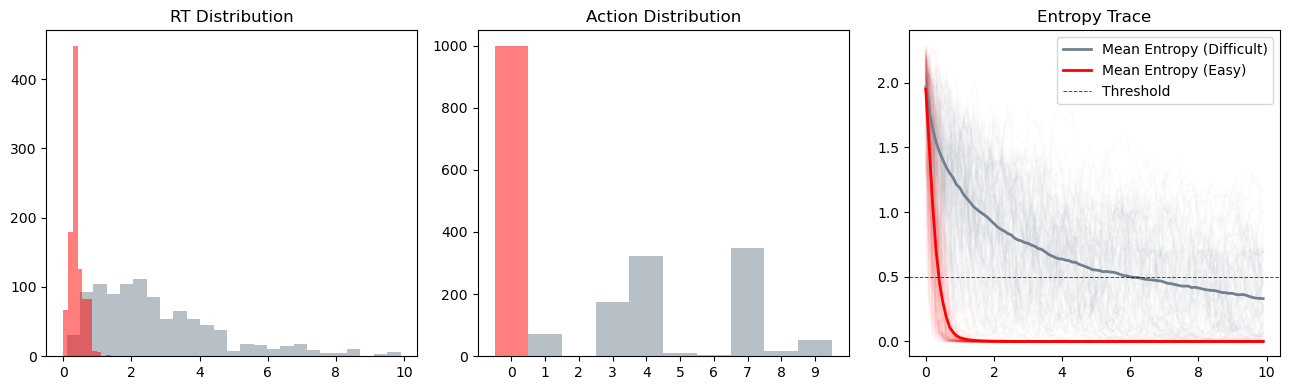

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(13, 4))
axs[0].hist(min_rts * dt, bins=25, color='slategray', alpha=0.5)
axs[0].hist(max_rts * dt, bins=10, color='red', alpha=0.5)
axs[0].set_title("RT Distribution")

bins = np.arange(11) - 0.5
axs[1].hist(min_actions, bins=bins, color='slategray', alpha=0.5)
axs[1].hist(max_actions, bins=bins, color='red', alpha=0.5)
axs[1].set_title("Action Distribution")
axs[1].set_xticks(np.arange(10))


axs[2].set_title("Entropy Trace")
for i in range(min(len(min_entropies), 100)):
    axs[2].plot(np.arange(len(min_entropies[i])) * dt, min_entropies[i], color='slategray', alpha=0.02)
    axs[2].plot(np.arange(len(max_entropies[i])) * dt, max_entropies[i], color='red', alpha=0.02)

axs[2].plot(np.arange(len(min_entropies[0])) * dt, np.mean(min_entropies, axis=0), color='slategray', linewidth=2, label='Mean Entropy (Difficult)')
axs[2].plot(np.arange(len(max_entropies[0])) * dt, np.mean(max_entropies, axis=0), color='red', linewidth=2, label='Mean Entropy (Easy)')

# plot line at threshold
axs[2].axhline(y=threshold, color='black', linestyle='--', label='Threshold', linewidth=.7, alpha=0.7)
axs[2].legend()

plt.tight_layout()

fig.savefig(f"{figures_path}/difficulty_comparison.svg", format='svg', dpi=300)

plt.show()

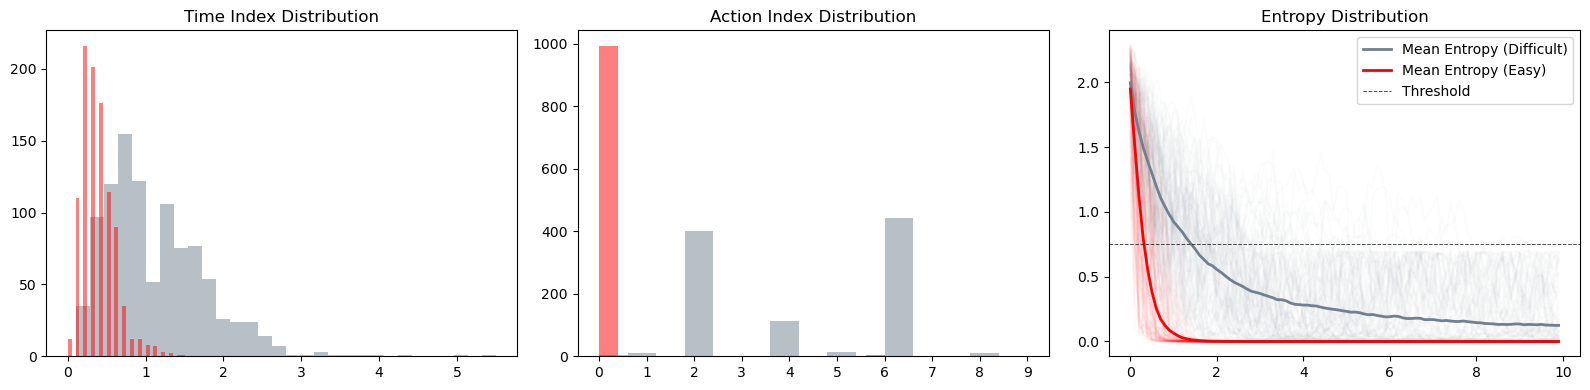

In [ ]:
threshold = 0.75
dt = .1

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
axs[0].hist(min_rts * dt, bins=30, color='slategray', alpha=0.5)
axs[0].hist(max_rts * dt, bins=30, color='red', alpha=0.5)
axs[0].set_title("Time Index Distribution")

axs[1].hist(min_actions, bins=15, color='slategray', alpha=0.5)
axs[1].hist(max_actions, bins=15, color='red', alpha=0.5)
axs[1].set_title("Action Index Distribution")
axs[1].set_xticks(np.arange(10))


axs[2].set_title("Entropy Distribution")
for i in range(min(len(min_entropies), 100)):
    axs[2].plot(np.arange(len(min_entropies[i])) * dt, min_entropies[i], color='slategray', alpha=0.02)
    axs[2].plot(np.arange(len(max_entropies[i])) * dt, max_entropies[i], color='red', alpha=0.02)

axs[2].plot(np.arange(len(min_entropies[0])) * dt, np.mean(min_entropies, axis=0), color='slategray', linewidth=2, label='Mean Entropy (Difficult)')
axs[2].plot(np.arange(len(max_entropies[0])) * dt, np.mean(max_entropies, axis=0), color='red', linewidth=2, label='Mean Entropy (Easy)')

# plot line at threshold
axs[2].axhline(y=threshold, color='black', linestyle='--', label='Threshold', linewidth=.7, alpha=0.7)
axs[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
mean_rts.mean() * .1

np.float64(0.8802560000000001)

In [ ]:
encoder = pssm.encoder.cpu()
dist,_,_,_ = encoder(max_img.unsqueeze(0).unsqueeze(0))
mean_rate_transformed = dist.rate.detach().numpy().squeeze().mean() * dt

print('mean poisson rates: ', mean_rate_transformed)

mean poisson rates:  0.3476464


In [ ]:
from run import evaluate

evaluate(pssm, ds_test, n_eval=20)

running evaluation...


  0%|          | 0/250 [00:00<?, ?it/s]

 36%|███▌      | 90/250 [00:01<00:01, 84.58it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

  0%|          | 0/5 [00:00<?, ?it/s]

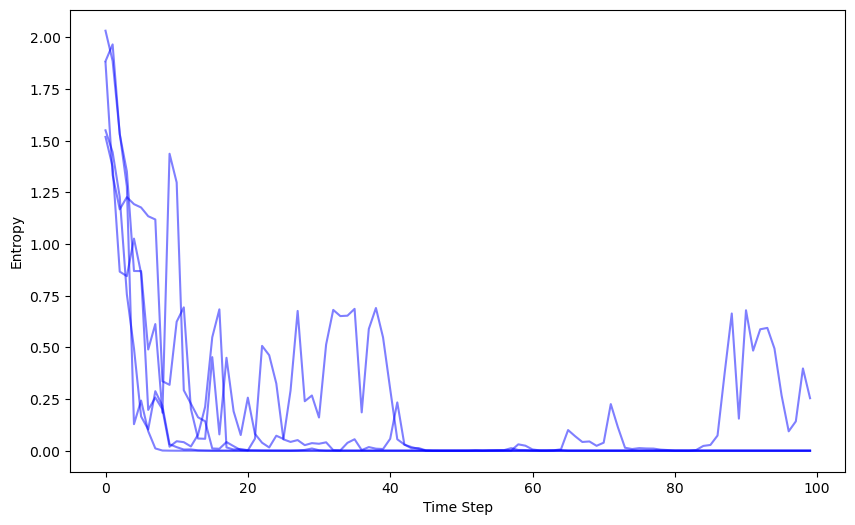

In [ ]:

from tqdm.notebook import tqdm
import numpy as np
from scipy.stats import entropy
import torch.nn as nn
from pssm.utils import cumulative_spike_matrix

threshold = .25
rts = []
fig, ax = plt.subplots(figsize=(10, 6))
for img in tqdm(ds_test[:5]):

    device = 'cpu'
    n_timesteps = 100
    encoder.eval().to(device)
    decoder.eval().to(device)

    dist, _, _, _ = encoder.forward(img.unsqueeze(0).unsqueeze(0).to(device))
    # encode the image into latent space
    # sample spikes train
    sample, indicator, times = dist.rsample(hard=True, return_indicator=True)
    # convert to cumulative spike matrix
    cumulative_matrix = cumulative_spike_matrix(indicator, times, n_steps=n_timesteps)

    #print("Cumulative matrix shape:", cumulative_matrix.shape)

    logits = [decoder(x.float().to(device)) for x in cumulative_matrix.T]
    probs = [nn.functional.softmax(logit, dim=-1) for logit in logits]
    entropies = [entropy(prob.detach().cpu().numpy()) for prob in probs]

    rts.append(np.where(np.array(entropies) < threshold)[0][0].item())


    ax.plot(torch.arange(100), entropies, label='Entropy', color='blue', alpha=0.5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Entropy')

plt.show()


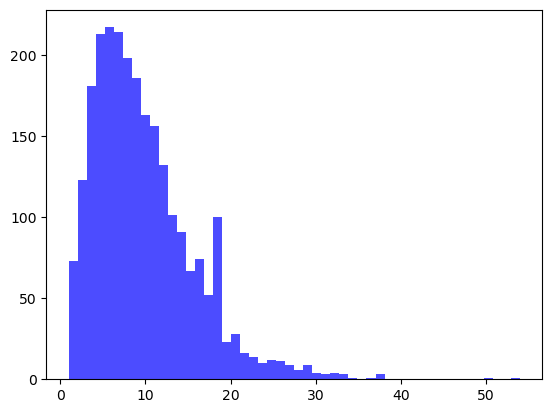

In [ ]:
#plot histogram of rts
plt.hist(rts, bins=50, color='blue', alpha=0.7)

plt.show()